In [1]:
import numpy as np
import cv2
from segment_anything import sam_model_registry,SamAutomaticMaskGenerator
import matplotlib.pyplot as plt 
import shutil 
import glob 
import os , sys 
from PIL import Image
import easyocr
sys.path.append("../../")
from typing import Tuple, List
import os
import subprocess
import shutil 

/var/.pyenv/versions/3.9.0/envs/monai@3.9.0/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:29: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
import logging
logging.basicConfig()
logger = logging.getLogger("uvicorn")

In [3]:
from core.segment_symbol.utils import calculate_iou, recognize_text,check_symbol_has_only_text,compare_images,find_closest_above_below


In [4]:
offset = 3 
iou_threshold = 0.1
width_min = 15
width_max = 200 
hw_ratio = 0.7
need_atleast_text_pixels = 50 
kernel_size = (3, 3)
min_image_size_again_get_text = 20

In [5]:
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")
sam.to(device="cuda")

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Input image of size (668, 659, 3)
Obtained  209 from segment anything


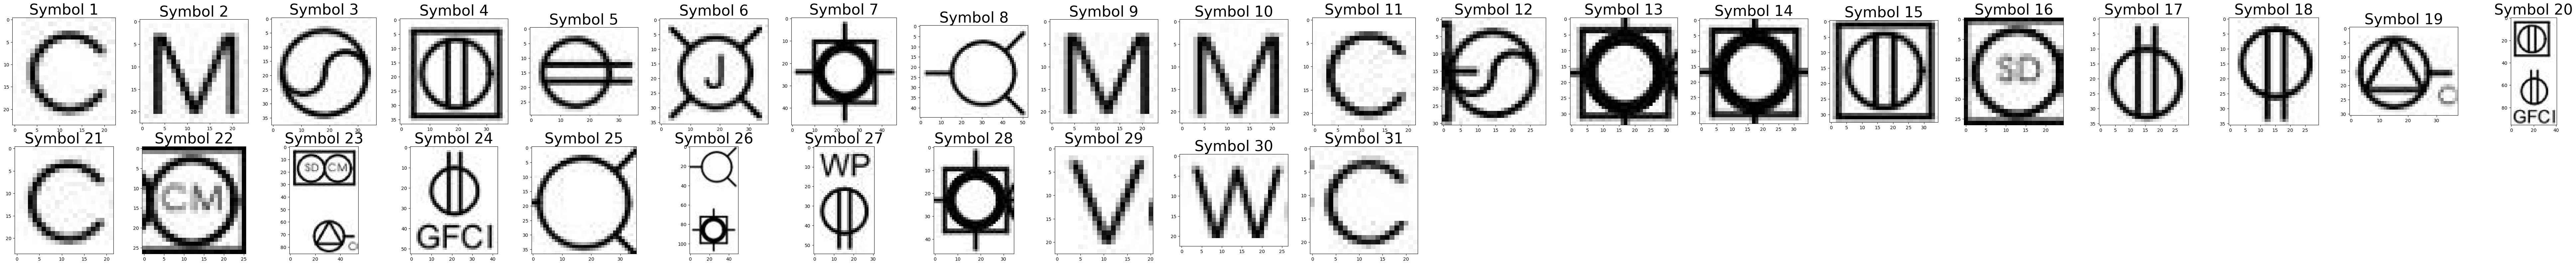

Filtered based on size of bboxes 31
Filtered bboxes after IOU 18
Filtered bboxes after Removing only with text 12


In [6]:
if(True):
        filtered_final_symbols = []
        mask_generator = SamAutomaticMaskGenerator(
                model=sam,
                points_per_side=32, # 64
                pred_iou_thresh=0.8,
                stability_score_thresh=0.8,
                box_nms_thresh = 0.8,
                crop_nms_thresh = 0.8, 
                crop_n_layers=1,
                crop_n_points_downscale_factor=2,
                min_mask_region_area=0,
            )

        image = cv2.imread("../../Examples/Example1/legends.png")
        print(f"Input image of size {image.shape}")
        masks = mask_generator.generate(image)
        print(f"Obtained  {len(masks)} from segment anything")

        # Initialize variables
        all_symbols = []


        # First, extract all potential bboxes
        for i, mask in enumerate(masks):
            bbox = mask["bbox"]
            x, y, w, h = [int(i) for i in bbox]
            if(width_min <= w < width_max and width_min <= h < width_max and h/w > hw_ratio):
                roi = image[y-offset: y + h+offset, x-offset  : x + w+offset]
                all_symbols.append((roi, bbox))

        plt.figure(figsize=(100,100))

        for i, (symbol,bbox) in enumerate(all_symbols):
            try:
                plt.subplot(20,20,i+1)
                plt.imshow(symbol)
                plt.title(f"Symbol {i+1}",fontsize=32) 
            except:
                pass 
            
        plt.show()
        
        print(f"Filtered based on size of bboxes {len(all_symbols)}")

        # Second, filter out bboxes based on IoU to remove dubplicates 
        filtered_symbols = []
        filtered_bboxes = []
        for i in range(len(all_symbols)):
            keep = True
            for j in range(len(all_symbols)):
                if i != j:
                    iou = calculate_iou(all_symbols[i][1], all_symbols[j][1])
                    if iou > iou_threshold:
                        # Keep the larger box
                        area_i = all_symbols[i][1][2] * all_symbols[i][1][3]
                        area_j = all_symbols[j][1][2] * all_symbols[j][1][3]
                        if area_i < area_j:
                            keep = False
                            break
            if keep:
                filtered_symbols.append(all_symbols[i][0])
                filtered_bboxes.append(all_symbols[i][1])


        print(f"Filtered bboxes after IOU {len(filtered_bboxes)}")

        filtered_bboxes_without_text = []
        filtered_symbols_without_text = []
        for i, (bbox,symbol) in enumerate(zip(filtered_bboxes,filtered_symbols)):
            result , symbol_has_only_text = check_symbol_has_only_text(255-symbol[:,:,0])
            if(not symbol_has_only_text):
                filtered_bboxes_without_text.append(bbox)
                filtered_symbols_without_text.append(symbol)

        print(f"Filtered bboxes after Removing only with text {len(filtered_symbols_without_text)}")


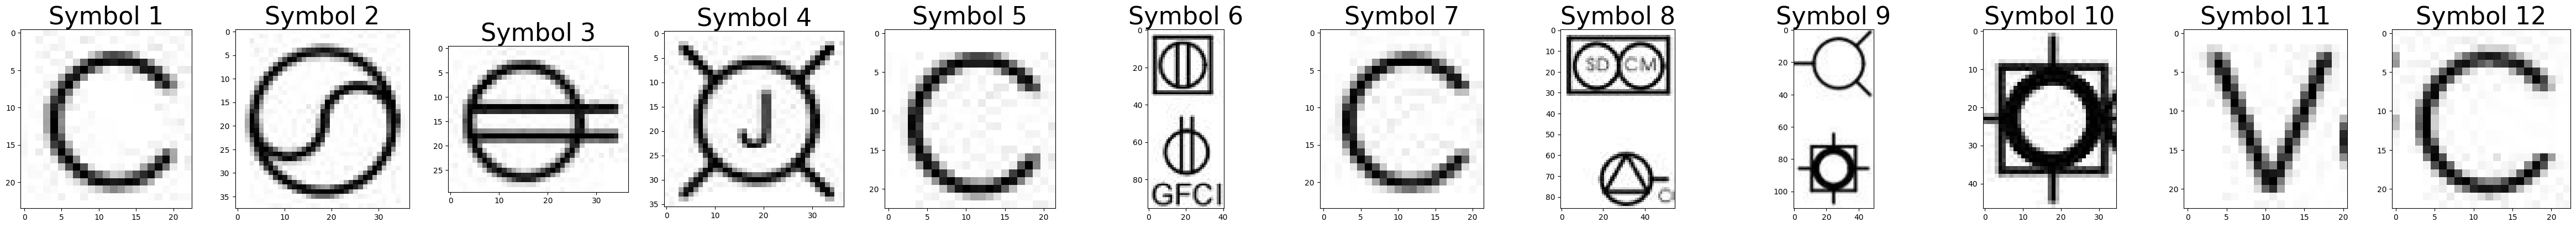

In [7]:
if(True): 
    plt.figure(figsize=(100,100))

    for i, symbol in enumerate(filtered_symbols_without_text):
        try:
            plt.subplot(20,20,i+1)
            plt.imshow(symbol)
            plt.title(f"Symbol {i+1}",fontsize=32) 
        except:
            pass 